## 1. Setting up the Environment

In [2]:
# # 1. Install Detectron2
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

# # 2. Install your dependencies BUT pin numpy to version 1.23.5
# # We use --force-reinstall to ensure it overwrites whatever version 2.x just got installed
# !pip install imgaug opencv-python "numpy==1.23.5" --force-reinstall

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-w_2jcoyo
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-w_2jcoyo
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.3 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6441602 sha256=374472ac544d41e7727cabc12c3c59da9ea10372ee0cda664e398220a626b522
  Stored in directory: /tmp/pip-ephem-wheel-cache-guyunulw/wheels/17/d9/40/60db98e485aa9455d653e29d1046601ce96fe23647f60c1c5a
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=f603c355f9070129b1bbbde8

In [2]:
# !python -m pip install "git+https://github.com/facebookresearch/detectron2.git"


  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-27uohef8
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-27uohef8
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.5 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6441605 sha256=e036a90034162c2133ab03ffbc495f9dd8901bf8f9f206c45da00fa1d7d14595
  Stored in directory: /tmp/pip-ephem-wheel-cache-iexz0_af/wheels/17/d9/40/60db98e485aa9455d653e29d1046601ce96fe23647f60c1c5a
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=682fc9c41db93e815da5106ae

## 2. Fixing the Dataset

train.json file contains labels for the entire 360,000+ dataset, but this dataset only has the images for "Part 0" (train-0). if not fixed, the training will crash immediately because it won't find the other images.

In [4]:
import json
import os
from pathlib import Path
import shutil

# --- CONFIGURATION BASED ON YOUR SCREENSHOTS ---
# Path to the folder containing your images
IMG_DIR = "/kaggle/input/documnet-layout-recognition-dataset-publaynet-t0/train-0/publaynet/train"

# Path to the original full annotation file
ORIGINAL_JSON = "/kaggle/input/documnet-layout-recognition-dataset-publaynet-t0/labels/publaynet/train.json"

# Output paths for our filtered files (saved in Kaggle's working directory)
FILTERED_TRAIN_JSON = "/kaggle/working/train_part0.json"
FILTERED_VAL_JSON = "/kaggle/working/val_part0.json"

def create_subset_json(json_path, img_dir, out_train, out_val, split_ratio=0.9):
    print("Loading original JSON labels... (this takes 30s)")
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Get the list of images effectively available in the disk
    available_imgs = set(os.listdir(img_dir))
    print(f"Found {len(available_imgs)} images in your train-0 folder.")

    # 1. Filter Images: Keep only the ones we have on disk
    valid_images = [img for img in data['images'] if img['file_name'] in available_imgs]
    valid_img_ids = set([img['id'] for img in valid_images])
    
    # 2. Filter Annotations: Keep only annotations for those images
    valid_annos = [ann for ann in data['annotations'] if ann['image_id'] in valid_img_ids]
    
    print(f"Filtered dataset to {len(valid_images)} images and {len(valid_annos)} annotations.")
    
    # 3. Create a Train/Val Split
    # We need a validation set to run the robustness tests later
    split_idx = int(len(valid_images) * split_ratio)
    train_imgs = valid_images[:split_idx]
    val_imgs = valid_images[split_idx:]
    
    # Helper to get annotations for specific images
    def get_annos_for_split(img_list):
        ids = set(img['id'] for img in img_list)
        return [ann for ann in valid_annos if ann['image_id'] in ids]

    # Structure for Train JSON
    train_data = {
        'images': train_imgs, 
        'annotations': get_annos_for_split(train_imgs), 
        'categories': data['categories']
    }
    
    # Structure for Validation JSON
    val_data = {
        'images': val_imgs, 
        'annotations': get_annos_for_split(val_imgs), 
        'categories': data['categories']
    }

    # Save to disk
    with open(out_train, 'w') as f:
        json.dump(train_data, f)
    with open(out_val, 'w') as f:
        json.dump(val_data, f)
        
    print(f"Saved filtered JSONs:\nTrain: {out_train}\nVal: {out_val}")

# Execute the function
create_subset_json(ORIGINAL_JSON, IMG_DIR, FILTERED_TRAIN_JSON, FILTERED_VAL_JSON)

Loading original JSON labels... (this takes 30s)
Found 47958 images in your train-0 folder.
Filtered dataset to 47958 images and 465838 annotations.
Saved filtered JSONs:
Train: /kaggle/working/train_part0.json
Val: /kaggle/working/val_part0.json


In [5]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances

# Use the same paths as in your subset code
TRAIN_JSON = "/kaggle/working/train_part0.json"
VAL_JSON   = "/kaggle/working/val_part0.json"
IMG_DIR    = "/kaggle/input/documnet-layout-recognition-dataset-publaynet-t0/train-0/publaynet/train"

# Register train and val datasets for part-0
register_coco_instances(
    "publaynet_train_part0",  # name used in cfg.DATASETS.TRAIN
    {},
    TRAIN_JSON,
    IMG_DIR,
)

register_coco_instances(
    "publaynet_val_part0",    # name used in cfg.DATASETS.TEST
    {},
    VAL_JSON,
    IMG_DIR,
)

print("Registered datasets:", list(DatasetCatalog.keys()))


Registered datasets: ['coco_2014_train', 'coco_2014_val', 'coco_2014_minival', 'coco_2014_valminusminival', 'coco_2017_train', 'coco_2017_val', 'coco_2017_test', 'coco_2017_test-dev', 'coco_2017_val_100', 'keypoints_coco_2014_train', 'keypoints_coco_2014_val', 'keypoints_coco_2014_minival', 'keypoints_coco_2014_valminusminival', 'keypoints_coco_2017_train', 'keypoints_coco_2017_val', 'keypoints_coco_2017_val_100', 'coco_2017_train_panoptic_separated', 'coco_2017_train_panoptic_stuffonly', 'coco_2017_train_panoptic', 'coco_2017_val_panoptic_separated', 'coco_2017_val_panoptic_stuffonly', 'coco_2017_val_panoptic', 'coco_2017_val_100_panoptic_separated', 'coco_2017_val_100_panoptic_stuffonly', 'coco_2017_val_100_panoptic', 'lvis_v1_train', 'lvis_v1_val', 'lvis_v1_test_dev', 'lvis_v1_test_challenge', 'lvis_v0.5_train', 'lvis_v0.5_val', 'lvis_v0.5_val_rand_100', 'lvis_v0.5_test', 'lvis_v0.5_train_cocofied', 'lvis_v0.5_val_cocofied', 'cityscapes_fine_instance_seg_train', 'cityscapes_fine_sem

## 3. Training Faster R-CNN on Clean Data

In [6]:
import detectron2
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.utils.events import JSONWriter, CommonMetricPrinter
from detectron2.data.datasets import register_coco_instances
import os

# --- 1. DEFINE A CUSTOM TRAINER THAT SKIPS TENSORBOARD ---
class NoTensorboardTrainer(DefaultTrainer):
    def build_writers(self):
        # Only return the screen printer and the JSON file saver.
        # Skip TensorboardXWriter which triggers the crash.
        return [
            CommonMetricPrinter(self.max_iter),
            JSONWriter(os.path.join(self.cfg.OUTPUT_DIR, "metrics.json")),
        ]

# --- 2. SETUP CONFIGURATION ---
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))

# === FIX: Use the names 'publaynet_train' matching what you registered earlier ===
cfg.DATASETS.TRAIN = ("publaynet_train_part0",)
cfg.DATASETS.TEST  = ("publaynet_val_part0",)


# =================================================================================

cfg.DATALOADER.NUM_WORKERS = 2

# Load pre-trained weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")

# Hyperparameters
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.MAX_ITER = 1000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# --- 3. START TRAINING WITH THE CUSTOM TRAINER ---
trainer = NoTensorboardTrainer(cfg)
trainer.resume_or_load(resume=False)
print("Starting Training (without Tensorboard)...")
trainer.train()

[12/02 14:42:57 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 261MB/s]                            
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_p

Starting Training (without Tensorboard)...
[12/02 14:43:08 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[12/02 14:43:20 d2.utils.events]:  eta: 0:07:25  iter: 19  total_loss: 6.893  loss_cls: 1.686  loss_box_reg: 0.7496  loss_rpn_cls: 3.891  loss_rpn_loc: 0.4981    time: 0.4483  last_time: 0.4542  data_time: 0.0235  last_data_time: 0.0087   lr: 1.9981e-05  max_mem: 4337M
[12/02 14:43:28 d2.utils.events]:  eta: 0:07:16  iter: 39  total_loss: 2.713  loss_cls: 1.396  loss_box_reg: 0.7545  loss_rpn_cls: 0.1627  loss_rpn_loc: 0.3524    time: 0.4429  last_time: 0.4607  data_time: 0.0082  last_data_time: 0.0071   lr: 3.9961e-05  max_mem: 4337M
[12/02 14:43:37 d2.utils.events]:  eta: 0:07:04  iter: 59  total_loss: 2.108  loss_cls: 0.8538  loss_box_reg: 0.7491  loss_rpn_cls: 0.1357  loss_rpn_loc: 0.3072    time: 0.4412  last_time: 0.4138  data_time: 0.0084  last_data_time: 0.0084   lr: 5.9941e-05  max_mem: 4337M
[12/02 14:43:46 d2.utils.events]:  eta: 0:06:53  iter: 79  total_loss: 1.949  loss_cls: 0.7404  loss_box_reg: 0.8128  loss_rpn_cls: 0.08789  loss_rpn_loc: 0.2907    time: 0.4403  last_tim

## 4. Defining the Perturbations (The Research Implementation)

In [23]:
import imgaug.augmenters as iaa
import numpy as np
import torch
from detectron2.data import DatasetMapper


class RoDLAPerturbations:
    def __init__(self):
        self.augmentations = {
            # ------------------ 1. Rotation ---------------------
            "Rotation_L1": iaa.Affine(rotate=(-5, 5), mode="edge"),
            "Rotation_L2": iaa.Affine(rotate=(-10, 10), mode="edge"),
            "Rotation_L3": iaa.Affine(rotate=(-15, 15), mode="edge"),

            # ------------------ 2. Warping -----------------------
            "Warping_L1": iaa.ElasticTransformation(alpha=10, sigma=4),
            "Warping_L2": iaa.ElasticTransformation(alpha=25, sigma=5),
            "Warping_L3": iaa.ElasticTransformation(alpha=40, sigma=6),

            # ------------------ 3. Keystoning --------------------
            "Keystoning_L1": iaa.PerspectiveTransform(scale=0.03),
            "Keystoning_L2": iaa.PerspectiveTransform(scale=0.06),
            "Keystoning_L3": iaa.PerspectiveTransform(scale=0.10),

            # ------------------ 4. Illumination Change ----------
            "Illumination_L1": iaa.Multiply((0.85, 1.15)),
            "Illumination_L2": iaa.Multiply((0.75, 1.25)),
            "Illumination_L3": iaa.Multiply((0.60, 1.40)),

            # ------------------ 5. Brightness/Color Shift -------
            "BrightnessColor_L1": iaa.AddToHueAndSaturation((-10, 10)),
            "BrightnessColor_L2": iaa.AddToHueAndSaturation((-20, 20)),
            "BrightnessColor_L3": iaa.AddToHueAndSaturation((-30, 30)),

            # ------------------ 6. Defocus Blur -----------------
            "Defocus_L1": iaa.GaussianBlur(1.0),
            "Defocus_L2": iaa.GaussianBlur(2.0),
            "Defocus_L3": iaa.GaussianBlur(3.0),

            # ------------------ 7. Motion Blur (REAL CATEGORY) --
            "MotionBlur_L1": iaa.MotionBlur(k=5),
            "MotionBlur_L2": iaa.MotionBlur(k=9),
            "MotionBlur_L3": iaa.MotionBlur(k=13),

            # ------------------ 8. Vibration (Jitter Blur) ------
            "Vibration_L1": iaa.MotionBlur(k=5, angle=(-10, 10)),
            "Vibration_L2": iaa.MotionBlur(k=8, angle=(-20, 20)),
            "Vibration_L3": iaa.MotionBlur(k=12, angle=(-30, 30)),

            # ------------------ 9. Speckle Noise ----------------
            "Speckle_L1": iaa.MultiplyElementwise((0.95, 1.05)),
            "Speckle_L2": iaa.MultiplyElementwise((0.90, 1.10)),
            "Speckle_L3": iaa.MultiplyElementwise((0.85, 1.15)),

            # ------------------ 10. Salt & Pepper ---------------
            "SaltPepper_L1": iaa.SaltAndPepper(0.01),
            "SaltPepper_L2": iaa.SaltAndPepper(0.03),
            "SaltPepper_L3": iaa.SaltAndPepper(0.05),

            # ------------------ 11. Texture ---------------------
            "Texture_L1": iaa.AdditiveGaussianNoise(scale=5),
            "Texture_L2": iaa.AdditiveGaussianNoise(scale=10),
            "Texture_L3": iaa.AdditiveGaussianNoise(scale=15),

            # ------------------ 12. JPEG / Downsampling ---------
            "JPEG_L1": iaa.JpegCompression(compression=20),
            "JPEG_L2": iaa.JpegCompression(compression=35),
            "JPEG_L3": iaa.JpegCompression(compression=55),

            "Downsample_L1": iaa.Sequential([iaa.Resize(0.9), iaa.Resize(1.0)]),
            "Downsample_L2": iaa.Sequential([iaa.Resize(0.75), iaa.Resize(1.0)]),
            "Downsample_L3": iaa.Sequential([iaa.Resize(0.60), iaa.Resize(1.0)]),
        }

    def apply(self, image, name):
        if name not in self.augmentations:
            return image
        aug = self.augmentations[name]
        return aug(image=image.astype(np.uint8))


class RobustMapper(DatasetMapper):
    def __init__(self, cfg, is_train=False, perturbation_name=None):
        super().__init__(cfg, is_train=is_train)
        self.perturb = RoDLAPerturbations()
        self.perturbation_name = perturbation_name

    def __call__(self, dataset_dict):
        d = super().__call__(dataset_dict)

        if not self.perturbation_name or self.perturbation_name == "None":
            return d

        img = d["image"].permute(1, 2, 0).cpu().numpy()  # CHW → HWC
        img = img.astype("uint8")

        img_aug = self.perturb.apply(img, self.perturbation_name)

        d["image"] = torch.as_tensor(
            img_aug.transpose(2, 0, 1).copy(), dtype=torch.float32
        )
        return d


### Fixing the json files to resolve 'info' error

pycocotools evaluator expects an 'info' section in the dataset JSON file which is standard for COCO format, but our custom filtering script from Step 2 only saved the images and annotations.

In [24]:
import json

# Define the paths (same as before)
FILTERED_TRAIN_JSON = "/kaggle/working/train_part0.json"
FILTERED_VAL_JSON = "/kaggle/working/val_part0.json"

def add_info_header(json_path):
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    # Check if 'info' is missing and add a dummy header
    if 'info' not in data:
        print(f"Fixing missing 'info' in {json_path}...")
        data['info'] = {
            "description": "PubLayNet Part0 Subset",
            "url": "",
            "version": "1.0",
            "year": 2025,
            "contributor": "Kaggle User",
            "date_created": "2025-01-01"
        }
        # Save it back
        with open(json_path, 'w') as f:
            json.dump(data, f)
        print("Success.")
    else:
        print(f"{json_path} already has 'info'.")

# Run the fix on both files
add_info_header(FILTERED_TRAIN_JSON)
add_info_header(FILTERED_VAL_JSON)

/kaggle/working/train_part0.json already has 'info'.
/kaggle/working/val_part0.json already has 'info'.


## 5. Run the Benchmark Loop

In [25]:
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader, MetadataCatalog
import numpy as np
import os

VAL_NAME = "publaynet_val_part0"
VAL_JSON = "/kaggle/working/val_part0.json"

# Fix metadata for evaluator
MetadataCatalog.get(VAL_NAME).set(
    json_file=VAL_JSON,
    evaluator_type="coco"
)

# Load trained model
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
predictor = DefaultPredictor(cfg)

# Compute clean AP once
print("Evaluating Clean baseline...")
evaluator_clean = COCOEvaluator(VAL_NAME, output_dir="./output_clean")
val_loader = build_detection_test_loader(cfg, VAL_NAME)
results_clean = inference_on_dataset(predictor.model, val_loader, evaluator_clean)

clean_ap = results_clean["bbox"]["AP"]
print("CLEAN AP =", clean_ap)

benchmark_results = {"Clean": clean_ap}  # store results


[12/02 16:34:12 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Evaluating Clean baseline...
[12/02 16:34:14 d2.data.datasets.coco]: Loading /kaggle/working/val_part0.json takes 1.04 seconds.
[12/02 16:34:14 d2.data.datasets.coco]: Loaded 4796 images in COCO format from /kaggle/working/val_part0.json
[12/02 16:34:15 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/02 16:34:15 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/02 16:34:15 d2.data.common]: Serializing 4796 elements to byte tensors and concatenating them all ...
[12/02 16:34:15 d2.data.common]: Serialized dataset takes 22.42 MiB
[12/02 16:34:15 d2.evaluation.evaluator]: Start inference on 4796 batches
[12/02 16:34:16 d2.evaluation.evaluator]: Inference done 11/4796. Dataloading: 0.0013 s/iter. Infe

### Rotation_L3, Warping_L3, Keystoning_L3

In [26]:
perturb_group_1 = [
    "Rotation_L3",
    "Warping_L3",
    "Keystoning_L3"
]

print("\n=== Running Group 1 perturbations ===")

for p in perturb_group_1:
    print(f"\nEvaluating {p} ...")
    mapper = RobustMapper(cfg, is_train=False, perturbation_name=p)
    loader = build_detection_test_loader(cfg, VAL_NAME, mapper=mapper)
    evaluator = COCOEvaluator(VAL_NAME, output_dir=f"./out_{p}")

    res = inference_on_dataset(predictor.model, loader, evaluator)
    ap = res["bbox"]["AP"]

    benchmark_results[p] = ap
    print(f"{p}: AP={ap:.2f}, Drop={(clean_ap - ap):.2f}")



=== Running Group 1 perturbations ===

Evaluating Rotation_L3 ...
[12/02 16:39:18 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/02 16:39:19 d2.data.datasets.coco]: Loaded 4796 images in COCO format from /kaggle/working/val_part0.json
[12/02 16:39:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/02 16:39:20 d2.data.common]: Serializing 4796 elements to byte tensors and concatenating them all ...
[12/02 16:39:20 d2.data.common]: Serialized dataset takes 22.42 MiB
[12/02 16:39:20 d2.evaluation.evaluator]: Start inference on 4796 batches
[12/02 16:39:22 d2.evaluation.evaluator]: Inference done 11/4796. Dataloading: 0.0023 s/iter. Inference: 0.0641 s/iter. Eval: 0.0003 s/iter. Total: 0.0667 s/iter. ETA=0:05:19
[12/02 16:39:27 d2.evaluation.evaluator]: Inference done 86/4796. Dataloading: 0.0034 s/iter. Inference

### Illumination_L3, BrightnessColor_L3, Defocus_L3

In [27]:
perturb_group_2 = [
    "Illumination_L3",
    "BrightnessColor_L3",
    "Defocus_L3"
]

print("\n=== Running Group 2 perturbations ===")

for p in perturb_group_2:
    print(f"\nEvaluating {p} ...")
    mapper = RobustMapper(cfg, is_train=False, perturbation_name=p)
    loader = build_detection_test_loader(cfg, VAL_NAME, mapper=mapper)
    evaluator = COCOEvaluator(VAL_NAME, output_dir=f"./out_{p}")

    res = inference_on_dataset(predictor.model, loader, evaluator)
    ap = res["bbox"]["AP"]

    benchmark_results[p] = ap
    print(f"{p}: AP={ap:.2f}, Drop={(clean_ap - ap):.2f}")



=== Running Group 2 perturbations ===

Evaluating Illumination_L3 ...
[12/02 16:55:55 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/02 16:55:56 d2.data.datasets.coco]: Loading /kaggle/working/val_part0.json takes 1.10 seconds.
[12/02 16:55:56 d2.data.datasets.coco]: Loaded 4796 images in COCO format from /kaggle/working/val_part0.json
[12/02 16:55:57 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/02 16:55:57 d2.data.common]: Serializing 4796 elements to byte tensors and concatenating them all ...
[12/02 16:55:57 d2.data.common]: Serialized dataset takes 22.42 MiB
[12/02 16:55:58 d2.evaluation.evaluator]: Start inference on 4796 batches
[12/02 16:55:59 d2.evaluation.evaluator]: Inference done 11/4796. Dataloading: 0.0025 s/iter. Inference: 0.0644 s/iter. Eval: 0.0003 s/iter. Total: 0.0672 s/iter. ETA=0:05:21


### MotionBlur_L3, Vibration_L3, Speckle_L3

In [28]:
perturb_group_3 = [
    "MotionBlur_L3",
    "Vibration_L3",
    "Speckle_L3"
]

print("\n=== Running Group 3 perturbations ===")

for p in perturb_group_3:
    print(f"\nEvaluating {p} ...")
    mapper = RobustMapper(cfg, is_train=False, perturbation_name=p)
    loader = build_detection_test_loader(cfg, VAL_NAME, mapper=mapper)
    evaluator = COCOEvaluator(VAL_NAME, output_dir=f"./out_{p}")

    res = inference_on_dataset(predictor.model, loader, evaluator)
    ap = res["bbox"]["AP"]

    benchmark_results[p] = ap
    print(f"{p}: AP={ap:.2f}, Drop={(clean_ap - ap):.2f}")



=== Running Group 3 perturbations ===

Evaluating MotionBlur_L3 ...
[12/02 17:12:19 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/02 17:12:20 d2.data.datasets.coco]: Loaded 4796 images in COCO format from /kaggle/working/val_part0.json
[12/02 17:12:20 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/02 17:12:20 d2.data.common]: Serializing 4796 elements to byte tensors and concatenating them all ...
[12/02 17:12:20 d2.data.common]: Serialized dataset takes 22.42 MiB
[12/02 17:12:21 d2.evaluation.evaluator]: Start inference on 4796 batches
[12/02 17:12:22 d2.evaluation.evaluator]: Inference done 11/4796. Dataloading: 0.0024 s/iter. Inference: 0.0639 s/iter. Eval: 0.0003 s/iter. Total: 0.0666 s/iter. ETA=0:05:18
[12/02 17:12:27 d2.evaluation.evaluator]: Inference done 87/4796. Dataloading: 0.0033 s/iter. Inferen

### SaltPepper_L3, Texture_L3, JPEG_L3, Downsample_L3 + mRD/mPE Summary

In [29]:
perturb_group_4 = [
    "SaltPepper_L3",
    "Texture_L3",
    "JPEG_L3",
    "Downsample_L3"
]

print("\n=== Running Group 4 perturbations ===")

for p in perturb_group_4:
    print(f"\nEvaluating {p} ...")
    mapper = RobustMapper(cfg, is_train=False, perturbation_name=p)
    loader = build_detection_test_loader(cfg, VAL_NAME, mapper=mapper)
    evaluator = COCOEvaluator(VAL_NAME, output_dir=f"./out_{p}")

    res = inference_on_dataset(predictor.model, loader, evaluator)
    ap = res["bbox"]["AP"]

    benchmark_results[p] = ap
    print(f"{p}: AP={ap:.2f}, Drop={(clean_ap - ap):.2f}")


# ---- Compute mPE & mRD (L3-only version) ----

def compute_mpe_l3(clean_ap, results):
    mpe = {}
    for name, ap in results.items():
        if name == "Clean":
            continue
        base = name.split("_")[0]
        drop_pct = 100 * max(clean_ap - ap, 0) / clean_ap
        mpe[base] = drop_pct
    return mpe

def compute_mrd_l3(mpe):
    return float(np.mean(list(mpe.values())))

mpe_l3 = compute_mpe_l3(clean_ap, benchmark_results)
mrd_l3 = compute_mrd_l3(mpe_l3)

print("\n=== FINAL ROBUSTNESS REPORT (L3 ONLY) ===")
print("Clean AP:", clean_ap)

print("\n--- mPE per perturbation (L3 only) ---")
for p, v in mpe_l3.items():
    print(f"{p:15s}: {v:.2f}%")

print("\nOverall mRD (L3):", f"{mrd_l3:.3f}")



=== Running Group 4 perturbations ===

Evaluating SaltPepper_L3 ...
[12/02 17:28:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/02 17:28:35 d2.data.datasets.coco]: Loaded 4796 images in COCO format from /kaggle/working/val_part0.json
[12/02 17:28:35 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/02 17:28:35 d2.data.common]: Serializing 4796 elements to byte tensors and concatenating them all ...
[12/02 17:28:35 d2.data.common]: Serialized dataset takes 22.42 MiB
[12/02 17:28:37 d2.evaluation.evaluator]: Start inference on 4796 batches
[12/02 17:28:38 d2.evaluation.evaluator]: Inference done 11/4796. Dataloading: 0.0025 s/iter. Inference: 0.0643 s/iter. Eval: 0.0003 s/iter. Total: 0.0671 s/iter. ETA=0:05:21
[12/02 17:28:43 d2.evaluation.evaluator]: Inference done 88/4796. Dataloading: 0.0032 s/iter. Inferen

## 6. Visualization

[12/02 17:52:17 d2.data.datasets.coco]: Loaded 4796 images in COCO format from /kaggle/working/val_part0.json


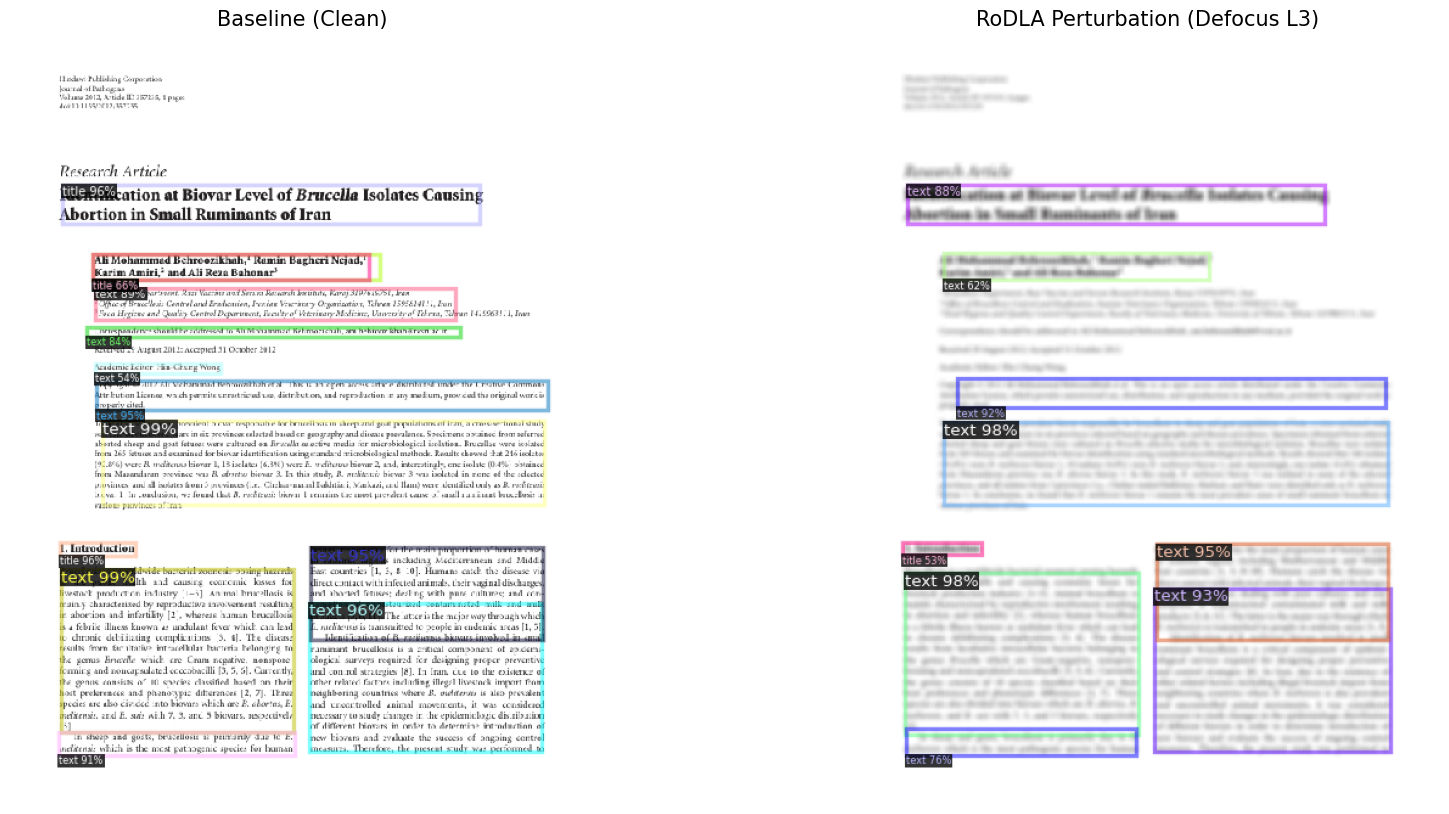

In [31]:
import cv2
import random
import matplotlib.pyplot as plt
import detectron2
from detectron2.utils.visualizer import Visualizer
from detectron2.data import DatasetCatalog, MetadataCatalog

VAL_NAME = "publaynet_val_part0"

# 1. Pick a random image from the validation set
dataset_dicts = list(DatasetCatalog.get(VAL_NAME))
d = random.sample(dataset_dicts, 1)[0]

# 2. Read the image
img_path = d["file_name"]
img = cv2.imread(img_path)             
metadata = MetadataCatalog.get(VAL_NAME)

# 3. Predict on CLEAN image
outputs_clean = predictor(img)

v_clean = Visualizer(img[:, :, ::-1], metadata=metadata, scale=0.8)
out_clean = v_clean.draw_instance_predictions(
    outputs_clean["instances"].to("cpu")
)

# 4. Predict on PERTURBED image (e.g. Defocus_L3)
perturber = RoDLAPerturbations()
img_noisy = perturber.apply(img, "Defocus_L3")   # choose any *_L3 here

outputs_noisy = predictor(img_noisy)

v_noisy = Visualizer(img_noisy[:, :, ::-1], metadata=metadata, scale=0.8)
out_noisy = v_noisy.draw_instance_predictions(
    outputs_noisy["instances"].to("cpu")
)

# 5. Plot side-by-side
fig, ax = plt.subplots(1, 2, figsize=(20, 10))

ax[0].imshow(out_clean.get_image())
ax[0].set_title("Baseline (Clean)", fontsize=15)
ax[0].axis("off")

ax[1].imshow(out_noisy.get_image())
ax[1].set_title("RoDLA Perturbation (Defocus L3)", fontsize=15)
ax[1].axis("off")

plt.show()


## 7. Creating the Front-End

### fixing and installing dependencies

In [3]:
# 2. Install Detectron2 
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

!pip install gradio imgaug "numpy<2.0" "scipy<1.13.0"

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-qzlr0v7k
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-qzlr0v7k
  Resolved https://github.com/facebookresearch/detectron2.git to commit fd27788985af0f4ca800bca563acdb700bb890e2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 8.7 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp311-cp311-linux_x86_64.whl size=6441608 sha256=b14cb01f3ec4ad3efb8ae985727dc0439e4ce142ef9cdd08738365326d1bb53c
  Stored in directory: /tmp/pip-ephem-wheel-cache-1dss2xsm/wheels/17/d9/40/60db98e485aa9455d653e29d1046601ce96fe23647f60c1c5a
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61397 sha256=a2278ac8a928010a685a2ec6d

In [34]:
import gradio as gr
import cv2
import numpy as np
import torch
import imgaug.augmenters as iaa
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

### Robustness engine

In [38]:
class RoDLAPerturbations:
    def __init__(self):
        self.augmentations = {
            "None": None,

            "Defocus Blur (L3)": iaa.GaussianBlur(sigma=3.0),
            "Motion Blur (L3)": iaa.MotionBlur(k=15, angle=(-30, 30)),

            "Speckle Noise (L3)": iaa.MultiplyElementwise(
                mul=(0.85, 1.15), per_channel=True
            ),
            "Salt & Pepper (L3)": iaa.SaltAndPepper(0.05),

            "Rotation (L3)": iaa.Affine(rotate=(-15, 15), mode="edge", cval=255),
            "Keystone Distortion (L3)": iaa.PerspectiveTransform(scale=(0.08, 0.12)),

            "Illumination Change (L3)": iaa.Sequential([
                iaa.Multiply((0.6, 1.4)),
                iaa.GammaContrast((0.7, 1.3)),
            ]),
            "Brightness & Color Shift (L3)": iaa.Sequential([
                iaa.AddToHueAndSaturation((-20, 20)),
                iaa.LinearContrast((0.7, 1.4)),
            ]),

            "Paper Texture (L3)": iaa.FrequencyNoiseAlpha(
                exponent=-2.0,
                first=iaa.AdditiveGaussianNoise(scale=(0, 0.04 * 255)),
                size_px_max=32,
            ),
            "Watermark Overlay (L3)": iaa.Sequential([
                iaa.FrequencyNoiseAlpha(
                    exponent=-2.0,
                    first=iaa.Multiply((0.7, 0.9), per_channel=True),
                    size_px_max=64,
                ),
                iaa.Alpha(0.35, iaa.Add((-40, -10))),
            ]),

            "JPEG Compression (L3)": iaa.JpegCompression(compression=(40, 60)),
            "Downsampling (L3)": iaa.Sequential([
                iaa.Resize({"height": 0.6, "width": 0.6}),
                iaa.Resize({"height": 1.0, "width": 1.0}),
            ]),
        }

    def apply(self, image, type_name):
        if type_name == "None" or type_name not in self.augmentations:
            return image
        aug = self.augmentations[type_name]
        return aug(image=image)


### setting up the model

In [39]:
def load_model():
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # text, title, list, table, figure
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Confidence Threshold
    
    # Use GPU if available (Kaggle has GPUs!)
    cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    
    # PATH TO YOUR UPLOADED WEIGHTS
    # (If this path fails, check the "Input" sidebar for the correct path)
    cfg.MODEL.WEIGHTS = "/kaggle/working/output/model_final.pth"
    
    return DefaultPredictor(cfg)

# Initialize
try:
    predictor = load_model()
    perturber = RoDLAPerturbations()
    
    # Manually register metadata for visualization
    meta_name = "rodla_demo_kaggle"
    try: MetadataCatalog.get(meta_name).set(thing_classes=["text", "title", "list", "table", "figure"])
    except: pass
    metadata = MetadataCatalog.get(meta_name)
    
    print("✅ Model Loaded Successfully!")
except Exception as e:
    print(f"❌ Error: {e}")
    print("Did you add the 'rodla-model-weights' dataset?")

[12/02 18:41:43 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /kaggle/working/output/model_final.pth ...
✅ Model Loaded Successfully!


/usr/local/lib/python3.11/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `FrequencyNoiseAlpha()` is deprecated. Use `BlendAlphaFrequencyNoise` instead. FrequencyNoiseAlpha is deprecated. Use BlendAlphaFrequencyNoise instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)
/usr/local/lib/python3.11/dist-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `Alpha()` is deprecated. Use `Alpha` instead. Alpha is deprecated. Use BlendAlpha instead. The order of parameters is the same. Parameter 'first' was renamed to 'foreground'. Parameter 'second' was renamed to 'background'.
  warn_deprecated(msg, stacklevel=3)


### app logic

In [40]:
def process_document(image, defect_type):
    if image is None: return None, "No image provided."
    
    # A. Apply Research Perturbation
    noisy_image = perturber.apply(image, defect_type)
    
    # B. Run Inference
    # Convert RGB -> BGR for Detectron2
    img_bgr = cv2.cvtColor(noisy_image, cv2.COLOR_RGB2BGR)
    outputs = predictor(img_bgr)
    
    # C. Visualize
    v = Visualizer(img_bgr[:, :, ::-1], metadata, scale=1.2)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    result_img = out.get_image()
    
    # D. Fraud/Quality Checks
    num_instances = len(outputs["instances"])
    scores = outputs["instances"].scores.cpu().numpy()
    avg_conf = np.mean(scores) if len(scores) > 0 else 0
    
    status = f"✅ PASSED: Found {num_instances} layout elements."
    if defect_type != "None":
        status += f" (Stress Test: {defect_type})"
    
    if num_instances < 3:
        status = "⚠️ ALERT: Low detection count. Document might be fake or low quality."
    elif avg_conf < 0.6:
        status = "⚠️ WARNING: Detections are low confidence."
        
    return result_img, status

### Launching the app

In [41]:
demo = gr.Interface(
    fn=process_document,
    inputs=[
        gr.Image(label="Upload Document"),
        gr.Radio(
            [
                "None",
                "Defocus Blur (L3)",
                "Motion Blur (L3)",
                "Speckle Noise (L3)",
                "Salt & Pepper (L3)",
                "Rotation (L3)",
                "Keystone Distortion (L3)",
                "Illumination Change (L3)",
                "Brightness & Color Shift (L3)",
                "Paper Texture (L3)",
                "Watermark Overlay (L3)",
                "JPEG Compression (L3)",
                "Downsampling (L3)",
            ],
            label="Simulate Scanning Defect",
            value="None",
        ),
    ],
    outputs=[
        gr.Image(label="Analysis Result"),
        gr.Textbox(label="System Status")
    ],
    title="📄 RoDLA Document Verification System",
    description="End-to-end demo of Robust Document Layout Analysis. Upload a document to verify its structure."
)

demo.launch(share=True, debug=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://19c84c8e48345d0c65.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/gradio/queueing.py", line 626, in process_events
    response = await route_utils.call_process_api(
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/route_utils.py", line 350, in call_process_api
    output = await app.get_blocks().process_api(
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 2235, in process_api
    result = await self.call_function(
             ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/gradio/blocks.py", line 1746, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/anyio/to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
           ^^^^^

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://19c84c8e48345d0c65.gradio.live
